#**02_TERM FREQUENCY AND TFIDF**

Summary:


1.   Load Back Data and Merging
2.   Split *narco_data* into Schedules ([DEA](https://www.dea.gov/drug-information/drug-scheduling))
3.   Term Frequency
4.   TfIdf on Schedule 1 and Schedule 2
5.   TfIdf with respect to Time Periods

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Università/inforet_prj/')

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import pickle
import spacy
import string
#import seaborn as sns; sns.set()
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

In [5]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

## **1. Load Back Data and Merging**

### *1.1 Split narco_nlp in 3 df to run convert_nlp_to_list*

In [ ]:
narco_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp.csv", sep="|", names=["spacy_nlp"])

In [ ]:
narco_df = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_df.csv", sep="|")
#narco_df

In [ ]:
# Convert back the original string from the form
#   text lemma POS; text lemma POS; text lemma POS; ...

def convert_nlp_to_list(row):
    if "; " not in row:
        return row.split()
    else:
        return [triplet.split() for triplet in row.split("; ")]

In [ ]:
narco_nlp_split = pd.concat([narco_nlp_1, narco_nlp_2, narco_nlp_3], ignore_index= True)

NameError: ignored

In [ ]:
narco_nlp_split.to_csv("narco_nlp_split.csv", index=False, sep="|")

In [ ]:
!cp narco_nlp_split.csv /content/drive/MyDrive/Università/inforet_prj

In [ ]:
#narco_nlp.spacy_nlp = narco_nlp.spacy_nlp.progress_apply(lambda row: convert_nlp_to_list(row))

In [ ]:
narco_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp.csv", sep="|", names=["spacy_nlp"])
narco_nlp_1 = narco_nlp[:12499]
narco_nlp_2 = narco_nlp[12499:25000]
narco_nlp_3 = narco_nlp[25000:]

In [ ]:
narco_nlp_1.spacy_nlp = narco_nlp_1.spacy_nlp.fillna("")

In [ ]:
narco_nlp_1.spacy_nlp = narco_nlp_1.spacy_nlp.progress_apply(lambda row: convert_nlp_to_list(row))

In [ ]:
narco_nlp_1.to_csv("narco_nlp_1.csv", index=False, sep="|")

In [ ]:
!cp narco_nlp_1.csv /content/drive/MyDrive/Università/inforet_prj

---

In [ ]:
narco_nlp_2.spacy_nlp = narco_nlp_2.spacy_nlp.fillna("")

In [ ]:
narco_nlp_2.spacy_nlp = narco_nlp_2.spacy_nlp.progress_apply(lambda row: convert_nlp_to_list(row))

In [ ]:
narco_nlp_2.to_csv("narco_nlp_2.csv", index=False, sep="|")

In [ ]:
!cp narco_nlp_2.csv /content/drive/MyDrive/Università/inforet_prj

---

In [ ]:
narco_nlp_3.spacy_nlp = narco_nlp_3.spacy_nlp.fillna("")

In [ ]:
narco_nlp_3.spacy_nlp = narco_nlp_3.spacy_nlp.progress_apply(lambda row: convert_nlp_to_list(row))

In [ ]:
narco_nlp_3.to_csv("narco_nlp_3.csv", index=False, sep="|")

In [ ]:
!cp narco_nlp_3.csv /content/drive/MyDrive/Università/inforet_prj

---

In [ ]:
narco_nlp_1 = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp_1.csv", sep="|"  )
narco_nlp_2 = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp_2.csv", sep="|"  )
narco_nlp_3 = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp_3.csv", sep="|"  )

---

### *1.2 Merge and Lemmatize*

In [27]:
narco_nlp_split = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp.csv", sep="|", names = ['spacy_nlp'], header=None)
narco_nlp_split

,spacy_nlp
0,was be AUX; indicted indict VERB; counts count...
1,trial trial NOUN; should should AUX; have have...
2,question question NOUN; presented present VERB...
3,issue issue NOUN; these these DET; consolidate...
4,plaintiff plaintiff NOUN; count count NOUN; co...
...,...
35405,jury jury NOUN; trial trial NOUN; defendant de...
35406,is be AUX; appeal appeal NOUN; from from ADP; ...
35407,have have AUX; duly duly ADV; served serve VER...
35408,parties party NOUN; have have AUX; stipulated ...


In [66]:
# Da useare in case narco_nlp contenga NA, e.g la pulizia ha dato problemi risultando in lista vuota.
if narco_nlp_split.loc[pd.isna(narco_nlp_split.spacy_nlp)].shape[0] > 0:
    narco_tmp = narco_df.loc[narco_df.index.isin(narco_nlp_split.loc[pd.isna(narco_nlp_split.spacy_nlp)].index)]
    narco_tmp.text = narco_tmp.text.progress_apply(lambda txt: full_text_clean(txt))
    narco_nlp_split.loc[pd.isna(narco_nlp_split.spacy_nlp), "spacy_nlp"] = narco_tmp.text

In [9]:
narco_df = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_df.csv", sep="|")
narco_df

,type,text,author,id,year
0,majority,CHIEF JUSTICE HEIPLE\ndelivered the opinion of...,CHIEF JUSTICE HEIPLE,1,1997
1,dissent,"JUSTICE HARRISON,\ndissenting:\nThe trial cour...","JUSTICE HARRISON,",1,1997
2,majority,JUSTICE FREEMAN\ndelivered the opinion of the ...,JUSTICE FREEMAN,4,1997
3,majority,JUSTICE BILANDIC\ndelivered the opinion of the...,JUSTICE BILANDIC,5,1997
4,majority,JUSTICE COLWELL\ndelivered the opinion of the ...,JUSTICE COLWELL,7,1997
...,...,...,...,...,...
35405,majority,PRESIDING JUSTICE QUINN\ndelivered the opinion...,PRESIDING JUSTICE QUINN,183124,2006
35406,majority,Mr. Justice Smith\ndelivered the opinion of th...,Mr. Justice Smith,183131,1947
35407,majority,Mb. Presiding Justice Stone\ndelivered the opi...,Mb. Presiding Justice Stone,183133,1938
35408,majority,"OPINION\nFrederick, J.\nThis cause comes befor...","Frederick, J. Frederick, J. Frederick, J.",183137,1999


In [78]:
def convert_nlp_to_lemma(row):
    if "; " not in row:
        return row
    else:
        return " ".join([triplet.split()[1] for triplet in row.split("; ")])

In [11]:
narco_nlp_split.spacy_nlp = narco_nlp_split.spacy_nlp.fillna("")

In [79]:
# TO SKIP WHEN WE'RE GONNA USE THE NEW FULL_TEXT_CLEAN,
# I.E THE ONE THAT OUTPUTS A STRING OF LEMMAS, SPACE-SEPARATED.
narco_nlp_split.spacy_nlp = narco_nlp_split.spacy_nlp.progress_apply(lambda row: convert_nlp_to_lemma(row))

100%|██████████| 35410/35410 [00:22<00:00, 1546.86it/s]


In [80]:
narco_nlp_split

,spacy_nlp
0,be indict count murder aggravate criminal sexu...
1,trial should have admit testimony from state p...
2,question present review be whether economic lo...
3,issue these consolidated appeal be constitutio...
4,plaintiff count complaint against defendant al...
...,...
35405,jury trial defendant be find hable medical mal...
35406,be appeal from judgment order county appellant...
35407,have duly serve within leave copy thereof corp...
35408,party have stipulate that actually square yard...


In [84]:
narco_data = pd.concat([narco_df, narco_nlp_split], axis=1)

In [85]:
narco_data = narco_data.rename(columns= {'spacy_nlp':'lemmatized'})
narco_data.lemmatized

0        be indict count murder aggravate criminal sexu...
1        trial should have admit testimony from state p...
2        question present review be whether economic lo...
3        issue these consolidated appeal be constitutio...
4        plaintiff count complaint against defendant al...
                               ...                        
35405    jury trial defendant be find hable medical mal...
35406    be appeal from judgment order county appellant...
35407    have duly serve within leave copy thereof corp...
35408    party have stipulate that actually square yard...
35409    be charge indictment count murder count armed ...
Name: lemmatized, Length: 35410, dtype: object

In [87]:
del narco_df
del narco_nlp_split

In [88]:
import gc
gc.collect()

1390

In [ ]:
def get_element_triplet(row, position=0, as_string=True):
    # Position = 0: extract token
    # Position = 1: extract lemma
    # Position = 2: extract POS
    # as_string = True: joined string; False: list.

    elem_list = [triplet[position] for triplet in row]

    if as_string:
        return " ".join(elem_list)
    else:
        return elem_list

In [ ]:
# Text cleaned, tokens
#text_cleaned = narco_data.spacy_nlp.progress_apply(lambda row: get_element_triplet(row, position=0, as_string=True))

In [ ]:
# List of POS
#all_pos = narco_data.spacy_nlp.progress_apply(lambda row: get_element_triplet(row, position=2, as_string=False))

In [ ]:
# Lemmatized data # 45 min
#narco_data['lemmatized'] = narco_data.spacy_nlp.progress_apply(lambda row: " ".join([y.lemma_ for y in nlp(get_element_triplet(row, position=1, as_string=True)) if not y.is_stop]))

In [90]:
def typo(text):
    cleaned_text = (
        text.replace('cannabi ','cannabis ')
        .replace('lysergic acid diethylamide', 'lsd')
        .replace('methylenedioxymethamphetamine', 'mdma')
        .replace('methylenedioxyamphetamine', 'mda')
        .replace('ciacetyl','diacetyl')
        .replace(' nar cotic', ' narcotic')
        .replace(' fi ','')
        )
    return cleaned_text

In [91]:
narco_data['lemmatized'] = narco_data.lemmatized.progress_apply(lambda txt: typo(txt))
#typo(narco_data.lemmatized[30])

100%|██████████| 35410/35410 [00:02<00:00, 12374.40it/s]


In [92]:
narco_data.loc[narco_data['lemmatized'].str.contains(' fi ')]

,type,text,author,id,year,lemmatized


### *1.1 Serialize narco_data*

In [93]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "wb") as f:
    pickle.dump(narco_data, f)

---

## **2. Split *narco_data* into Schedules**

In [6]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
    narco_data = pickle.load(f)

In [8]:
schedule_1 = ["cannabis",  "marijuana",  "lsd", "heroin", 'methaqualone', "ecstasy", "peyote", "mescaline", "mda", "mdma"] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "hydromorphone", "dilaudid", "meperidine", "demerol", "oxycodone", "dexedrine", "fentanyl", "ritalin", "methadone", "amphetamine", "phencyclidine", "pseudoephedrine", "ephedrine", "meth", "opium", "dilaudid", "preludin"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone", "ketamine"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura", "soma", "xanax", "darvon", "darvocet", "valium", "ativan", "talwin", "ambien", "tramadol",  "ethclorvynol"]
schedule_5 = ["phenylpropanolamine", "lomotil", "motofen", "lyrica", "parepectolin", "tetracaine"]

In [9]:
conditions = [
    (narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5)))
    ]

# create a list of the values we want to assign for each condition
values = ['narco_1', 'narco_2', 'narco_3', 'narco_4']

# create a new column and use np.select to assign values to it using our lists as arguments
narco_data['schedule'] = np.select(conditions, values)

# display updated DataFrame
narco_data.head()

,type,text,author,id,year,lemmatized,schedule
0,majority,CHIEF JUSTICE HEIPLE\ndelivered the opinion of...,CHIEF JUSTICE HEIPLE,1,1997,be indict count murder aggravate criminal sexu...,narco_2
1,dissent,"JUSTICE HARRISON,\ndissenting:\nThe trial cour...","JUSTICE HARRISON,",1,1997,trial should have admit testimony from state p...,narco_2
2,majority,JUSTICE FREEMAN\ndelivered the opinion of the ...,JUSTICE FREEMAN,4,1997,question present review be whether economic lo...,narco_2
3,majority,JUSTICE BILANDIC\ndelivered the opinion of the...,JUSTICE BILANDIC,5,1997,issue these consolidated appeal be constitutio...,0
4,majority,JUSTICE COLWELL\ndelivered the opinion of the ...,JUSTICE COLWELL,7,1997,plaintiff count complaint against defendant al...,narco_2


Take here data if you want to analyze differences between years.

In [12]:
narco_sch = narco_data.loc[:, ["schedule", "lemmatized"]]

In [13]:
narco_sch

,schedule,lemmatized
0,narco_2,be indict count murder aggravate criminal sexu...
1,narco_2,trial should have admit testimony from state p...
2,narco_2,question present review be whether economic lo...
3,0,issue these consolidated appeal be constitutio...
4,narco_2,plaintiff count complaint against defendant al...
...,...,...
35405,narco_2,jury trial defendant be find hable medical mal...
35406,narco_2,be appeal from judgment order county appellant...
35407,narco_2,have duly serve within leave copy thereof corp...
35408,narco_2,party have stipulate that actually square yard...


In [14]:
# NARCO SCHEDULE MERGE
# Merge in one row all the opinions in the same schedule.
# We obtain narco_schedule with shape 5,2:
#   _0 (miscellaneous), narco_1, narco_2, narco_3, narco_4;
#   _schedule label and lemmatized corpora.

narco_schedule = narco_sch.groupby('schedule', as_index=False).agg({'lemmatized' : ' '.join}) 

In [18]:
narco_schedule.lemmatized.str.split(" ").map(len)

0     6317862
1     1388421
2    48309426
3       15927
4      110722
Name: lemmatized, dtype: int64

### *2.1 Serialize narco_schedule*

In [19]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "wb") as f:
    pickle.dump(narco_schedule, f)

---

## **3. Term Frequency**

In [4]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "rb") as f:
  narco_schedule = pickle.load(f)

In [5]:
# Divide 
# narco_schedule.loc[narco_schedule.schedule == "0"] #7341 
narco_schedule_1 = narco_schedule.loc[narco_schedule['schedule']=="narco_1"] # 1471    
narco_schedule_2 = narco_schedule.loc[narco_schedule['schedule']=="narco_2"] # 2965   
#narco_schedule_3 = narco_schedule.loc[narco_schedule['schedule']=="narco_3"] # 11
#narco_schedule_4 = narco_schedule.loc[narco_schedule['schedule']=="narco_4"] # 23

In [6]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [8]:
vectorizer = CountVectorizer()
vector_narco = vectorizer.fit_transform(nar['lemmatized'])

words_list = vectorizer.get_feature_names()
count_list = vector_narco.toarray().sum(axis=0)

w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}

mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]

mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)

mcw[:50]

100%|██████████| 64862/64862 [00:11<00:00, 5590.23it/s]


,words_tot,abs_freq,rel_freq
0,be,2800749,0.056
1,that,2018683,0.041
2,have,835788,0.017
3,defendant,725071,0.015
4,or,574297,0.012
5,it,487049,0.010
6,his,471981,0.009
7,which,378709,0.008
8,from,339756,0.007
9,trial,338789,0.007


In [9]:
vectorizer = CountVectorizer()
#words_list = vectorizer.get_feature_names()
#
X = vectorizer.fit_transform(narco_schedule_1['lemmatized'])
words_list_1 = vectorizer.get_feature_names()
count_list_1 = X.toarray().sum(axis=0)
w_1 = dict(zip(words_list_1, count_list_1))
w_1 = {k: v for k, v in sorted(w_1.items(), key=lambda item: item[1], reverse=True)}
mcw_1 = pd.DataFrame.from_dict(w_1, orient='index').reset_index()
mcw_1.columns = ["words_1", "abs_freq"]
mcw_1["rel_freq"] = mcw_1.progress_apply(lambda x: np.round(x.abs_freq / mcw_1.abs_freq.sum(), 3), axis=1)
mcw_1["log_freq"] = mcw_1.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_1["augm_freq"] = mcw_1.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_1.abs_freq.max()), 3), axis=1)
#
Y = vectorizer.fit_transform(narco_schedule_2['lemmatized'])
words_list_2 = vectorizer.get_feature_names()
count_list_2 = Y.toarray().sum(axis=0)
w_2 = dict(zip(words_list_2, count_list_2))
w_2 = {k: v for k, v in sorted(w_2.items(), key=lambda item: item[1], reverse=True)}
mcw_2 = pd.DataFrame.from_dict(w_2, orient='index').reset_index()
mcw_2.columns = ["words_2", "abs_freq"]
mcw_2["rel_freq"] = mcw_2.progress_apply(lambda x: np.round(x.abs_freq / mcw_2.abs_freq.sum(), 3), axis=1)
mcw_2["log_freq"] = mcw_2.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_2["augm_freq"] = mcw_2.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_2.abs_freq.max()), 3), axis=1)

100%|██████████| 64300/64300 [00:09<00:00, 6583.62it/s]


In [10]:
mcw_1_2_concat = pd.concat([mcw_1[:20],mcw_2[:20]], axis=1)
mcw_1_2_concat # WORDS = tinfou, mitte, wtappe

,words_1,abs_freq,rel_freq,log_freq,augm_freq,words_2,abs_freq,rel_freq,log_freq,augm_freq
0,be,79419,0.057,8.010,1.000,be,2721330,0.056,10.206,1.000
1,that,58900,0.042,7.824,0.871,that,1959783,0.041,10.002,0.860
2,defendant,38983,0.028,7.568,0.745,have,811203,0.017,9.454,0.649
3,have,24585,0.018,7.282,0.655,defendant,686088,0.014,9.350,0.626
4,his,17830,0.013,7.082,0.612,or,561788,0.012,9.226,0.603
5,trial,14920,0.011,6.971,0.594,it,476478,0.010,9.123,0.588
6,or,12509,0.009,6.862,0.579,his,454151,0.009,9.094,0.583
7,it,10571,0.008,6.757,0.567,which,368971,0.008,8.965,0.568
8,evidence,9870,0.007,6.715,0.562,from,330680,0.007,8.896,0.561
9,which,9738,0.007,6.706,0.561,trial,323869,0.007,8.884,0.560


In [11]:
common_terms = list(set(mcw_1["words_1"][:10].values).intersection(set(mcw_2["words_2"][:200].values)))
common_terms

['or',
 'evidence',
 'defendant',
 'be',
 'it',
 'have',
 'which',
 'trial',
 'that',
 'his']

In [12]:
# COMMON
a = mcw.words_tot[:50]
b = mcw_1.words_1[:50]
c = mcw_2.words_2[:50]
ab = pd.DataFrame([ element for element in a if element in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element in c], columns = ['narco1_narco2'])
#x = pd.concat([ab, ac,bc],axis=1 ) 
bc

,narco1_narco2


In [13]:
df_top50 = pd.concat([a, b, c],axis=1) ## MOLTO STRANO!!
df_top50[:10]

,words_tot,words_1,words_2
0,be,be,be
1,that,that,that
2,have,defendant,have
3,defendant,have,defendant
4,or,his,or
5,it,trial,it
6,his,or,his
7,which,it,which
8,from,evidence,from
9,trial,which,trial


In [14]:
# NOT COMMON ## NON FUNZIONA?!
a = mcw.words_tot[:30]
b = mcw_1.words_1[:30]
c = mcw_2.words_2[:30]
ab = pd.DataFrame([ element for element in a if element not in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element not in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element not in c], columns = ['narco1_narco2'])
x = pd.concat([ab, ac,bc], axis=1 ) 
x

,tot_narco1,tot_narco2,narco1_narco2
0,be,be,be
1,that,that,that
2,have,have,defendant
3,defendant,defendant,have
4,or,or,his
5,it,it,trial
6,his,his,or
7,which,which,it
8,from,from,evidence
9,trial,trial,which


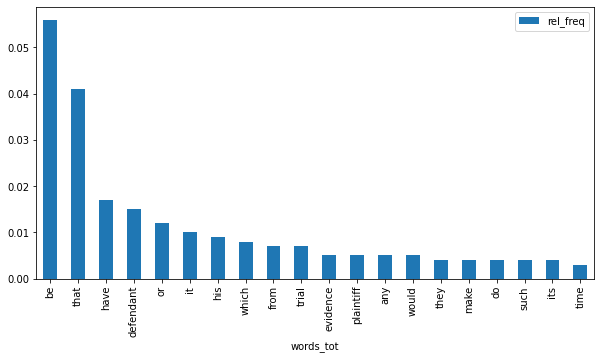

In [15]:
mcw[:20].plot(x="words_tot", y="rel_freq", kind="bar", figsize=(10,5)) 
plt.show()

In [ ]:
mcw["augm_freq"] = mcw.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw.abs_freq.max()), 3), axis=1)

100%|██████████| 26401/26401 [00:03<00:00, 8687.00it/s]


Text(0, 0.5, 'Augemnted Frequency')

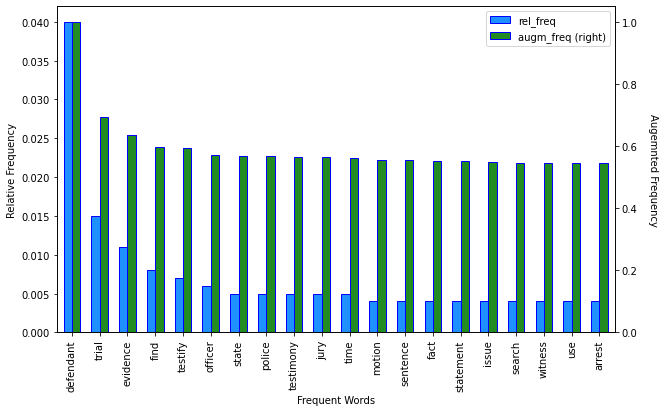

In [ ]:
mcw_freqs = mcw[['words_tot','rel_freq','augm_freq']]
ax = mcw_freqs[:20].plot(kind='bar', x = 'words_tot', secondary_y = 'augm_freq', color={"rel_freq": "dodgerblue", "augm_freq": "forestgreen"}, edgecolor='blue', figsize=(10,6), width= 0.6)

ax.set_xlabel("Frequent Words")
ax.set_ylabel("Relative Frequency")
plt.ylabel('Augemnted Frequency', rotation=-90, labelpad=20)

---

## **4. TfIdf on Schedule 1 and Schedule 2**

In [ ]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [ ]:
nar

,schedule,lemmatized
1,narco_1,appeal order dismiss untimely postconviction p...
2,narco_2,indict count murder aggravate criminal sexual ...


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(nar['lemmatized'])
tfidf_1 = tfidf_vectorizer.transform(narco_schedule_1['lemmatized'])
tfidf_2 = tfidf_vectorizer.transform(narco_schedule_2['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_1=sort_coo(tfidf_1.tocoo())
items_2=sort_coo(tfidf_2.tocoo())
keyw_1=extract_topn_from_vector(feature_names,items_1,30)
keyw_2=extract_topn_from_vector(feature_names,items_2,30)
keyw_1 = pd.DataFrame(list(keyw_1.items()),columns = ['word_1','tfidf_1'])
keyw_2 = pd.DataFrame(list(keyw_2.items()),columns = ['word_2','tfidf_2']) 
tfidf_schedule_drugs = pd.concat([keyw_1, keyw_2], axis=1)
tfidf_schedule_drugs

,word_1,tfidf_1,word_2,tfidf_2
0,defendant,0.719,defendant,0.701
1,trial,0.261,trial,0.280
2,evidence,0.178,evidence,0.195
3,find,0.137,find,0.134
4,officer,0.130,testify,0.133
5,testify,0.128,state,0.101
6,police,0.109,jury,0.096
7,search,0.099,police,0.093
8,testimony,0.095,testimony,0.092
9,sentence,0.092,officer,0.088


In [ ]:
#int_df = pd.merge(keyw_1, keyw_2, how ='inner', on =['word', 'word'])
#print(int_df)

In [ ]:
pd.DataFrame([ element for element in keyw_1.word_1[:20] if element not in keyw_2.word_2[:20]], columns = ['tot_narco1']) ## NON FUNZIONA!!

,tot_narco1
0,defendant
1,trial
2,evidence
3,find
4,officer
5,testify
6,police
7,search
8,testimony
9,sentence


---

## **5. TfIdf with respect to Time Periods**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
  narco_data = pickle.load(f)

In [ ]:
schedule_1 = ["cannabis",  "marijuana",  "lsd", "heroin", 'methaqualone', "ecstasy", "peyote" ] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "hydromorphone", "dilaudid", "meperidine", "demerol", "oxycodone", "dexedrine", "fentanyl", "ritalin", "methadone"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura"] #SMART DRUGS 

#### 5.1 **Schedule 1**: *narco_1_time* building

In [ ]:
narco_data_1 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1741 

In [ ]:
narco_1_time = narco_data_1.drop(['type','text','author', 'id','spacy_nlp'], axis = 1)

In [ ]:
#narco_1_time['year'].astype(str).astype(int)

In [ ]:
narco_1_time.loc[(narco_1_time["year"] >= 1950) & (narco_1_time["year"] <= 1959), 'year'] = 50 # 33
narco_1_time.loc[(narco_1_time["year"] >= 1960) & (narco_1_time["year"] <= 1969), 'year'] = 60 # 222
narco_1_time.loc[(narco_1_time["year"] >= 1970) & (narco_1_time["year"] <= 1979), 'year'] = 70 # 560
narco_1_time.loc[(narco_1_time["year"] >= 1980) & (narco_1_time["year"] <= 1989), 'year'] = 80 # 414
narco_1_time.loc[(narco_1_time["year"] >= 1990) & (narco_1_time["year"] <= 1999), 'year'] = 90 # 251
narco_1_time.loc[(narco_1_time["year"] >= 2000) & (narco_1_time["year"] <= 2009), 'year'] = 10 # 229

In [ ]:
narco_1_time.loc[narco_1_time["year"] == 50, 'year'] = '50s' 
narco_1_time.loc[narco_1_time["year"] == 60, 'year'] = '60s' 
narco_1_time.loc[narco_1_time["year"] == 70, 'year'] = '70s' 
narco_1_time.loc[narco_1_time["year"] == 80, 'year'] = '80s' 
narco_1_time.loc[narco_1_time["year"] == 90, 'year'] = '90s'
narco_1_time.loc[narco_1_time["year"] == 10, 'year'] = '00s'

In [ ]:
narco_1_time.loc[narco_1_time.year == '00s'].shape

In [ ]:
narco_1_time.drop(narco_1_time.loc[(narco_1_time["year"] != '50s' ) & (narco_1_time["year"] != '60s') & (narco_1_time["year"] != '70s') & (narco_1_time["year"] != '80s') & (narco_1_time["year"] != '90s') & (narco_1_time["year"] != '00s')].index, inplace=True)

In [ ]:
narco_1_time = narco_1_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [ ]:
narco_1_50s = narco_1_time.loc[narco_1_time['year']=="50s"] # 2507  
narco_1_60s = narco_1_time.loc[narco_1_time['year']=="60s"] 
narco_1_70s = narco_1_time.loc[narco_1_time['year']=="70s"]
narco_1_80s = narco_1_time.loc[narco_1_time['year']=="80s"]
narco_1_90s = narco_1_time.loc[narco_1_time['year']=="90s"]
narco_1_00s = narco_1_time.loc[narco_1_time['year']=="00s"]

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_1_time.pkl", "wb") as f:
    pickle.dump(narco_1_time, f)

#### 5.2 **Schedule 1**: TfIdf *narco_1_time*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_1_time.pkl", "rb") as f:
  narco_1_time = pickle.load(f)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_1_time['lemmatized'])
tfidf_50_59 = tfidf_vectorizer.transform(narco_1_50s['lemmatized'])
tfidf_60_69 = tfidf_vectorizer.transform(narco_1_60s['lemmatized'])
tfidf_70_79 = tfidf_vectorizer.transform(narco_1_70s['lemmatized'])
tfidf_80_89 = tfidf_vectorizer.transform(narco_1_80s['lemmatized'])
tfidf_90_99 = tfidf_vectorizer.transform(narco_1_90s['lemmatized'])
tfidf_00_09 = tfidf_vectorizer.transform(narco_1_00s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_50_59=sort_coo(tfidf_50_59.tocoo())
items_60_69=sort_coo(tfidf_60_69.tocoo())
items_70_79=sort_coo(tfidf_70_79.tocoo())
items_80_89=sort_coo(tfidf_80_89.tocoo())
items_90_99=sort_coo(tfidf_90_99.tocoo())
items_00_09=sort_coo(tfidf_00_09.tocoo())
keyw_50_59=extract_topn_from_vector(feature_names,items_50_59,30)
keyw_60_69=extract_topn_from_vector(feature_names,items_60_69,30)
keyw_70_79=extract_topn_from_vector(feature_names,items_70_79,30)
keyw_80_89=extract_topn_from_vector(feature_names,items_80_89,30)
keyw_90_99=extract_topn_from_vector(feature_names,items_90_99,30)
keyw_00_09=extract_topn_from_vector(feature_names,items_00_09,30)
keyw_50_59 = pd.DataFrame(list(keyw_50_59.items()),columns = ['word_50','tfidf'])
keyw_60_69 = pd.DataFrame(list(keyw_60_69.items()),columns = ['word_60','tfidf']) 
keyw_70_79 = pd.DataFrame(list(keyw_70_79.items()),columns = ['word_70','tfidf']) 
keyw_80_89 = pd.DataFrame(list(keyw_80_89.items()),columns = ['word_80','tfidf']) 
keyw_90_99 = pd.DataFrame(list(keyw_90_99.items()),columns = ['word_90','tfidf']) 
keyw_00_09 = pd.DataFrame(list(keyw_00_09.items()),columns = ['word_95','tfidf'])

In [ ]:
tfidf_years = pd.concat([keyw_50_59, keyw_60_69, keyw_70_79, keyw_80_89, keyw_90_99, keyw_00_09], axis=1)
tfidf_years

#### **5.2 Schedule 2**: *narco_2_time* building

In [ ]:
narco_data_2 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1770 

In [ ]:
narco_2_time = narco_data_2.drop(['type','text','author', 'id','spacy_nlp'], axis = 1)

In [ ]:
# 5-years blocks between 1980 and 2009.
narco_2_time.loc[(narco_2_time["year"] >= 1980) & (narco_2_time["year"] <= 1984), 'year'] = 80 # 102
narco_2_time.loc[(narco_2_time["year"] >= 1985) & (narco_2_time["year"] <= 1989), 'year'] = 85 # 233
narco_2_time.loc[(narco_2_time["year"] >= 1990) & (narco_2_time["year"] <= 1994), 'year'] = 90 # 566
narco_2_time.loc[(narco_2_time["year"] >= 1995) & (narco_2_time["year"] <= 1999), 'year'] = 95 # 292
narco_2_time.loc[(narco_2_time["year"] >= 2000) & (narco_2_time["year"] <= 2004), 'year'] = 00 # 350
narco_2_time.loc[(narco_2_time["year"] >= 2005) & (narco_2_time["year"] <= 2009), 'year'] = 5 # 278

In [ ]:
narco_2_time.loc[narco_2_time["year"] == 80, 'year'] = '80s' 
narco_2_time.loc[narco_2_time["year"] == 85, 'year'] = '85s' 
narco_2_time.loc[narco_2_time["year"] == 90, 'year'] = '90s' 
narco_2_time.loc[narco_2_time["year"] == 95, 'year'] = '95s' 
narco_2_time.loc[narco_2_time["year"] == 00, 'year'] = '00s'
narco_2_time.loc[narco_2_time["year"] == 5, 'year'] = '05s'

In [ ]:
narco_2_time.drop(narco_2_time.loc[(narco_2_time["year"] != '80s' ) & (narco_2_time["year"] != '85s') & (narco_2_time["year"] != '90s') & (narco_2_time["year"] != '95s') & (narco_2_time["year"] != '00s') & (narco_2_time["year"] != '05s')].index, inplace=True)

In [ ]:
narco_2_time = narco_2_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_2_time.pkl", "wb") as f:
    pickle.dump(narco_2_time, f)

#### **5.4 Schedule 2**: TfIdf *narco_2_time*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_2_time.pkl", "rb") as f:
  narco_2_time = pickle.load(f)

In [ ]:
# Create new df for each period (from 80s to 00s)
narco_2_80s = narco_2_time.loc[narco_2_time['year']=="80s"] # 2507  
narco_2_85s = narco_2_time.loc[narco_2_time['year']=="85s"] 
narco_2_90s = narco_2_time.loc[narco_2_time['year']=="90s"]
narco_2_95s = narco_2_time.loc[narco_2_time['year']=="95s"]
narco_2_00s = narco_2_time.loc[narco_2_time['year']=="00s"]
narco_2_05s = narco_2_time.loc[narco_2_time['year']=="05s"]

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_2_time['lemmatized'])
tfidf_80_84_2 = tfidf_vectorizer.transform(narco_2_80s['lemmatized'])
tfidf_85_89_2 = tfidf_vectorizer.transform(narco_2_85s['lemmatized'])
tfidf_90_94_2 = tfidf_vectorizer.transform(narco_2_90s['lemmatized'])
tfidf_95_00_2 = tfidf_vectorizer.transform(narco_2_95s['lemmatized'])
tfidf_00_04_2 = tfidf_vectorizer.transform(narco_2_00s['lemmatized'])
tfidf_05_09_2 = tfidf_vectorizer.transform(narco_2_05s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_80_84_2 = sort_coo(tfidf_80_84_2.tocoo())
items_85_89_2 = sort_coo(tfidf_85_89_2.tocoo())
items_90_94_2 = sort_coo(tfidf_90_94_2.tocoo())
items_95_00_2 = sort_coo(tfidf_95_00_2.tocoo())
items_00_05_2 = sort_coo(tfidf_00_04_2.tocoo())
items_05_09_2 = sort_coo(tfidf_05_09_2.tocoo())
keyw_80_84_2 = extract_topn_from_vector(feature_names,items_80_84_2,30)
keyw_85_89_2 = extract_topn_from_vector(feature_names,items_85_89_2,30)
keyw_90_94_2 = extract_topn_from_vector(feature_names,items_90_94_2,30)
keyw_95_00_2 = extract_topn_from_vector(feature_names,items_95_00_2,30)
keyw_00_05_2 = extract_topn_from_vector(feature_names,items_00_05_2,30)
keyw_05_09_2 = extract_topn_from_vector(feature_names,items_05_09_2,30)
keyw_80_84_2 = pd.DataFrame(list(keyw_80_84_2.items()),columns = ['word_80','tfidf'])
keyw_85_89_2 = pd.DataFrame(list(keyw_85_89_2.items()),columns = ['word_85','tfidf']) 
keyw_90_94_2 = pd.DataFrame(list(keyw_90_94_2.items()),columns = ['word_90','tfidf']) 
keyw_95_00_2 = pd.DataFrame(list(keyw_95_00_2.items()),columns = ['word_95','tfidf']) 
keyw_00_05_2 = pd.DataFrame(list(keyw_00_05_2.items()),columns = ['word_00','tfidf']) 
keyw_05_09_2 = pd.DataFrame(list(keyw_05_09_2.items()),columns = ['word_05','tfidf'])

In [ ]:
tfidf_years_2 = pd.concat([keyw_80_84_2, keyw_85_89_2, keyw_90_94_2, keyw_95_00_2, keyw_00_05_2, keyw_05_09_2], axis=1)
tfidf_years_2

## **PMI**

In [ ]:
narco_1_pmi_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_1_pmi_nlp.csv", sep="|" , names=["sentences_lemma"] )
narco_1_pmi = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_1_pmi.csv", sep="|" )

In [ ]:
narco_1_pmi = pd.concat([narco_1_pmi, narco_1_pmi_nlp], axis=1)
narco_1_pmi = narco_1_pmi.drop(['type','text','author', 'sentences_joined'], axis = 1)

In [ ]:
narco_1_pmi